In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn.functional as F

In [2]:
import torch 
print(torch.__version__)

1.7.1


# Make data

In [3]:
x = np.linspace(-3, 3, 1000)
x_ = np.linspace(-3, 3, 1000)

In [4]:
x.size

1000

In [5]:
y = x**2 + 3 *np.random.uniform(size=x.size)
y = x**2 + 3* (x-2) *np.random.uniform(size=x.size)
y_ = -x_**2 + 3*np.random.uniform(size=x_.size)

In [6]:
# x = np.concatenate([x,x_])
# y = np.concatenate([y,y_])

In [7]:
f = lambda x : x**2

x = np.linspace(-3,3,300)
mean_list = f(x)
#y = f(x) + np.random.uniform(low=-1.0,high=1.0,size=x.shape)* 4* np.cos(x/2+.5)
y = f(x) + np.random.normal(0,1,size=x.shape) + np.random.normal(1,1,size=x.shape)

y_ = -y
x = np.concatenate((x,x), axis=0)
y = np.concatenate((y,y_),axis =0)
len(x)
len(y)

600

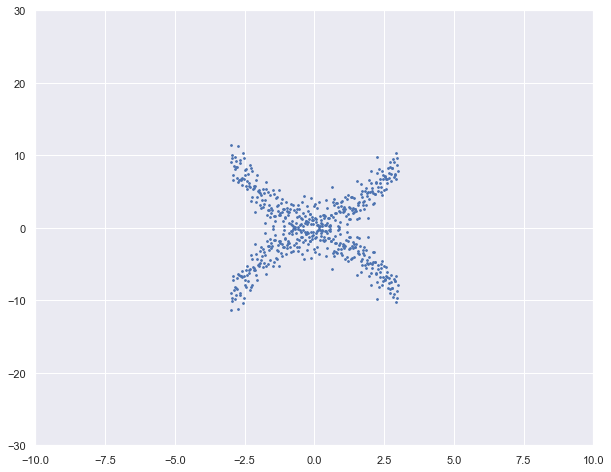

In [8]:
plt.figure(figsize=(10,8))
plt.xlim(-10,10)
plt.ylim(-30,30)
plt.scatter(x, y,s=3)

In [9]:
class MoG(torch.distributions.Distribution):
  def __init__(self, loc, covariance_matrix):
    self.num_components = loc.size(0)
    self.loc = loc
    self.covariance_matrix = covariance_matrix

    self.dists = [
      torch.distributions.MultivariateNormal(mu+x**2, covariance_matrix=sigma)
      for mu, sigma in zip(self.loc, self.covariance_matrix)
    ]

    super(MoG, self).__init__(torch.Size([]), torch.Size([loc.size(-1)]))

  @property
  def arg_constraints(self):
    return self.dists[0].arg_constraints

  @property
  def support(self):
    return self.dists[0].support

  @property
  def has_rsample(self):
    return False

  def log_prob(self, x, value):
    self.dists = [
      torch.distributions.MultivariateNormal(mu+x**2, covariance_matrix=sigma)
      for mu, sigma in zip(self.loc, self.covariance_matrix)
    ]
    return torch.cat(
      [p.log_prob(value).unsqueeze(-1) for p in self.dists], dim=-1).logsumexp(dim=-1)

  def enumerate_support(self):
    return dists[0].enumerate_support()

In [10]:
loc = torch.Tensor([[-1], [1]])
cov = torch.Tensor([1]).diag().unsqueeze(0).repeat(2, 1, 1)

mog2 = MoG(loc,cov)

In [11]:
class MoG(torch.distributions.Distribution):
  def __init__(self, loc, covariance_matrix):
    self.num_components = loc.size(0)
    self.loc = loc
    self.covariance_matrix = covariance_matrix

    self.dists = [
      torch.distributions.MultivariateNormal(mu, covariance_matrix=sigma)
      for mu, sigma in zip(loc, covariance_matrix)
    ]
    
    super(MoG, self).__init__(torch.Size([]), torch.Size([loc.size(-1)]))

  @property
  def arg_constraints(self):
    return self.dists[0].arg_constraints

  @property
  def support(self):
    return self.dists[0].support

  @property
  def has_rsample(self):
    return False

  def log_prob(self, value):
    return torch.cat(
      [p.log_prob(value).unsqueeze(-1) for p in self.dists], dim=-1).logsumexp(dim=-1)

  def enumerate_support(self):
    return self.dists[0].enumerate_support()


class MoG2(MoG):
  def __init__(self, device=None):
    loc = torch.Tensor([[-5.0, 0.0], [5.0, 0.0]])
    cov = torch.Tensor([0.5, 0.5]).diag().unsqueeze(0).repeat(2, 1, 1)

    super(MoG2, self).__init__(loc, cov)
    
mog2 = MoG2()

# Define net

In [12]:
class G(nn.Module):
    def __init__(self,hidden_size=50, noise_dim=5):
        super().__init__()
        self.noise_dim = noise_dim
        self.fc1 = nn.Linear(1,hidden_size,bias=False)
        self.fc_noise = nn.Linear(self.noise_dim,hidden_size,bias=False)
        self.concate_layer_bias = nn.Parameter(torch.zeros(hidden_size))
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        
        self.fc1.weight.data.normal_(0,0.02)
        self.fc_noise.weight.data.normal_(0,0.02)
        self.fc2.weight.data.normal_(0,0.02)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.out.weight.data.normal_(0,0.02)
        nn.init.constant_(self.out.bias, 0.0)
        
    def forward(self, input, num_particle=5):
        n_dims = input.dim()
        # 2
        sample_shape = list(input.shape)
        # N * in_dim
        sample_shape[n_dims-1:] = (num_particle, self.noise_dim)
        # N * n_part * obs_dim
        sample_shape = torch.Size(list(sample_shape))
        
        expanded_inputs = []
        input_expanded = input.unsqueeze(n_dims-1)
        
        # N * 1 * obs_dim
        expanded_inputs.append(input_expanded)
        xi = torch.randn(sample_shape).cpu()
        # N * n_part * obs_dim
        expanded_inputs.append(Variable(xi))
        
         # Apply the concate layer
        concate_layers = [self.fc1, self.fc_noise]
        result = self.concate_layer_bias
        # hidden_size
        for var, layer in zip(expanded_inputs, concate_layers):
            result = result + layer(var)
        # N * n_part * hidden_size
        
        result = F.relu(result)
        result = F.relu(self.fc2(result))
        # N * n_part * hidden_size
        out = self.out(result)
        # N * n_part * out_dim
        return out

In [13]:
class D(nn.Module):
    def __init__(self,hidden_size=50):
        super().__init__()
        self.fc_in = nn.Linear(1, hidden_size,bias=False)
        self.fc_out = nn.Linear(1, hidden_size,bias=False)
        self.concate_layer_bias = nn.Parameter(torch.zeros(hidden_size))
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        
        self.fc_in.weight.data.normal_(0,0.02)
        self.fc_out.weight.data.normal_(0,0.02)
        self.fc2.weight.data.normal_(0,0.02)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.out.weight.data.normal_(0,0.02)
        nn.init.constant_(self.out.bias, 0.0)
        
    def forward(self, input, output):
        # input and output are in/out of G, not D
        # the output of D is energy (log-prob)
        
        expanded_inputs = []
        expanded_inputs.append(input.unsqueeze(-1))
        expanded_inputs.append(output)
        
        # Apply the concate layer
        concate_layers = [self.fc_in, self.fc_out]
        result = self.concate_layer_bias
        # hidden_size
        for var, layer in zip(expanded_inputs, concate_layers):
            result = result + layer(var)
        # N * n_part * hidden_size
        
        result = F.relu(result)
        result = F.relu(self.fc2(result))
        # N * n_part * hidden_size
        energy = self.out(result)
        # N * n_part * out_dim
        
        return energy

# Calculate the amortized Stein Variational Gradient

$$
\begin{eqnarray}
\eta^{t+1} &\leftarrow \eta^{t} + \epsilon \frac{1}{m}\sum_{i=1}^m \partial_{\eta}f(\xi_i ; \eta^t) \phi^* (z_i)\\
&\leftarrow \eta^{t} + \epsilon \frac{1}{nm} \sum_{i=1}^m \partial_{\eta}f(\xi_i ; \eta^t) \sum_{j=1}^{n} \big[ \nabla_{z_j} \log p(z_j) k(z_j, z_i) + \nabla_{z_j}k(z_j,z_i) \big]\\
\end{eqnarray}
$$

In [14]:
def rbf_kernel(input_1, input_2,  h_min=1e-3):
    k_fix, out_dim1 = input_1.size()[-2:]
    k_upd, out_dim2 = input_2.size()[-2:]
    assert out_dim1 == out_dim2

    leading_shape = input_1.size()[:-2]
    # Compute the pairwise distances of left and right particles.
    diff = input_1.unsqueeze(-2) - input_2.unsqueeze(-3)  
    # N * k_fix * 1 * out_dim / N * 1 * k_upd * out_dim/ N * k_fix * k_upd * out_dim
    dist_sq = diff.pow(2).sum(-1)
    # N * k_fix * k_upd
    dist_sq = dist_sq.unsqueeze(-1)
    # N * k_fix * k_upd * 1
    
    # Get median.
    median_sq = torch.median(dist_sq, dim=1)[0]
    median_sq = median_sq.unsqueeze(1)
    # N * 1 * k_upd * 1
    
    h = median_sq / np.log(k_fix + 1.)
    # N * 1 * k_upd * 1

    kappa = torch.exp(- dist_sq / h)
    # N * k_fix * k_upd * 1

    # Construct the gradient
    kappa_grad = -2. * diff / h * kappa
    return kappa, kappa_grad

def eval_svgd(g_net,d_net, input, target, num_particle=10, alpha=1.):
    z_i = g_net.forward((Variable(torch.FloatTensor(input)).view(-1,1).cpu()),\
                      num_particle=num_particle)
    # N * k_upd * out_dim
    z_j = g_net.forward((Variable(torch.FloatTensor(input)).view(-1,1).cpu()),
                      num_particle=num_particle)
    # N * k_fix * out_dim
    
    # N * k_fix * out_dim
    score = d_net(Variable(torch.FloatTensor(input)).view(-1,1).cpu(), z_j)
    grad_score = autograd.grad(score.sum(), z_j)[0].unsqueeze(2)
    # N * k_fix * 1 * out_dim
    kappa, grad_kappa = rbf_kernel(z_j, z_i)
    # N * k_fix * k_upd / N * k_fix * k_upd * 1
    
    svgd = torch.mean( kappa*grad_score + alpha*grad_kappa, dim=1 ).detach()
    # N * k_fix * k_upd * out_dim -> N * k_upd * out_dim
    
    g_optim.zero_grad()
    autograd.backward(
        -z_i,
    grad_tensors=svgd)
    g_optim.step()
    
def d_learn(g_net,d_net, input, target, num_particle=10):
    z = g_net.forward((Variable(torch.FloatTensor(input)).view(-1,1).cpu()),
                  num_particle=num_particle)
    # N * k_upd * 1
    eps = torch.rand(z.size()).cpu()
    z_flow = (1-eps)*z + eps* Variable(torch.FloatTensor(target)).view(-1,1,1).cpu()
    # N * k_upd * 1

    # energy calc
    g_energy = d_net(Variable(torch.FloatTensor(input)).view(-1,1).cpu(), z)
    # N * k_upd * 1
    data_energy = d_net(Variable(torch.FloatTensor(input)).view(-1,1).cpu(),\
                        Variable(torch.FloatTensor(target)).view(-1,1,1).cpu())
    # N * 1 * 1
    flow_energy = d_net(Variable(torch.FloatTensor(input)).view(-1,1).cpu(), z_flow)
    # N * k_upd * 1

    loss = -data_energy.mean()+g_energy.mean()
    grad = autograd.grad( flow_energy.sum(), z_flow ,retain_graph=True )[0].norm()
    loss = loss + 10. * (grad-1)**2

    d_optim.zero_grad()
    autograd.backward(
        loss
    )
    d_optim.step()

# Test it!

C:\Users\a\anaconda3\lib\site-packages\torch\autograd\__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


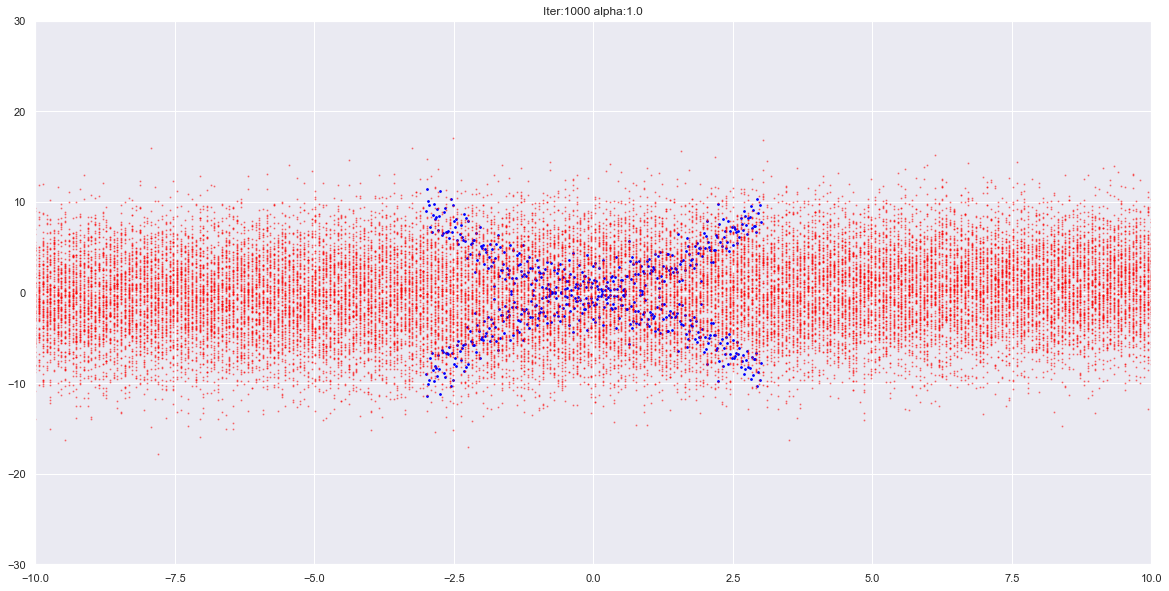

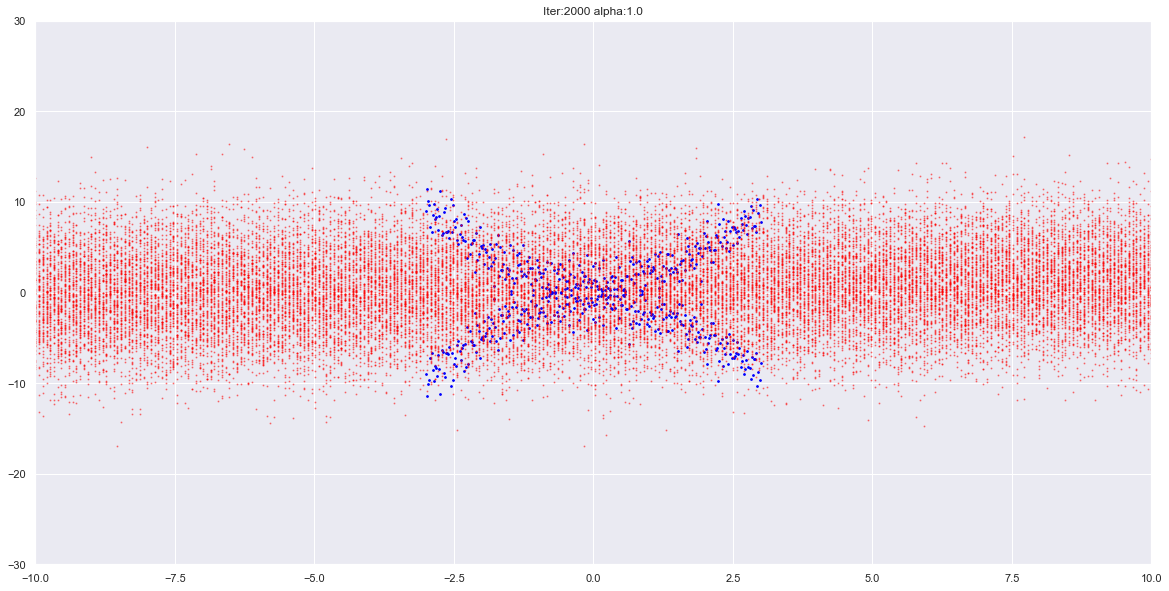

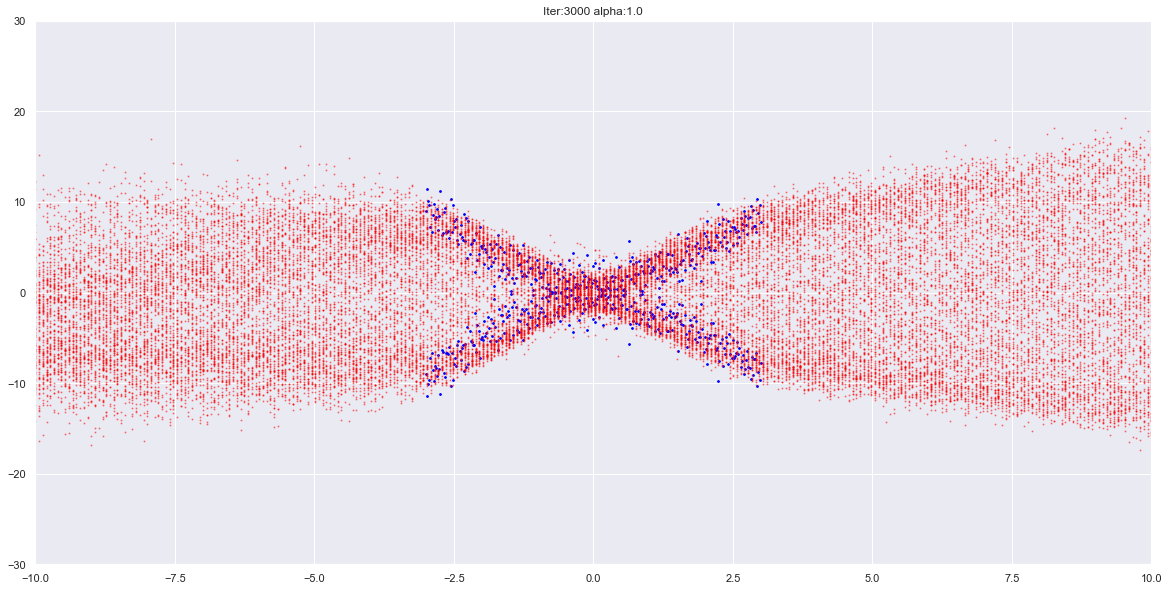

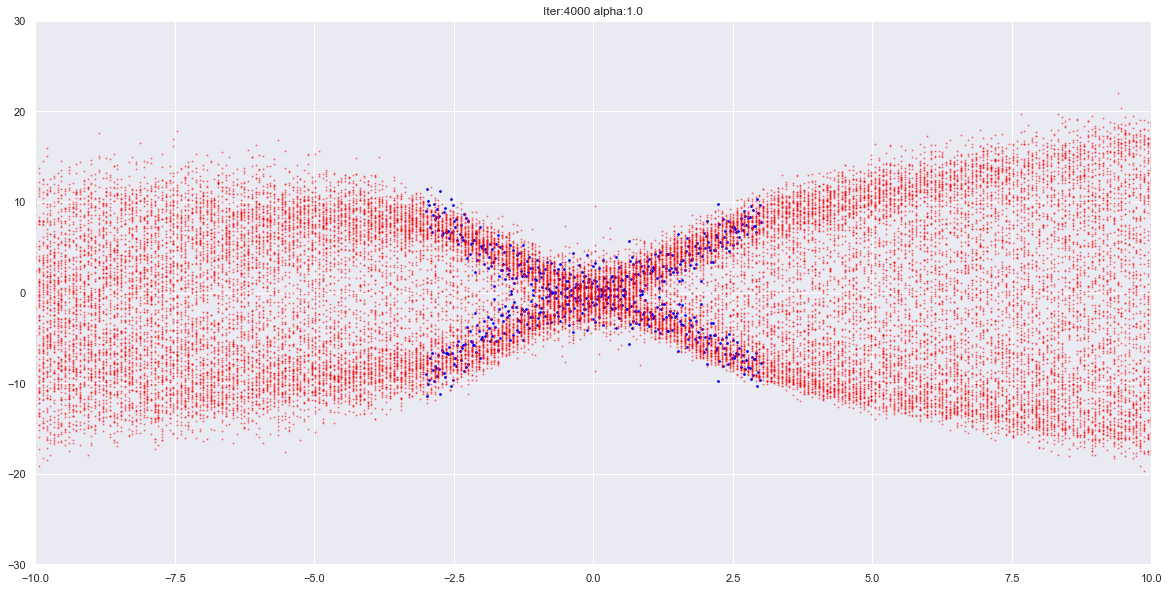

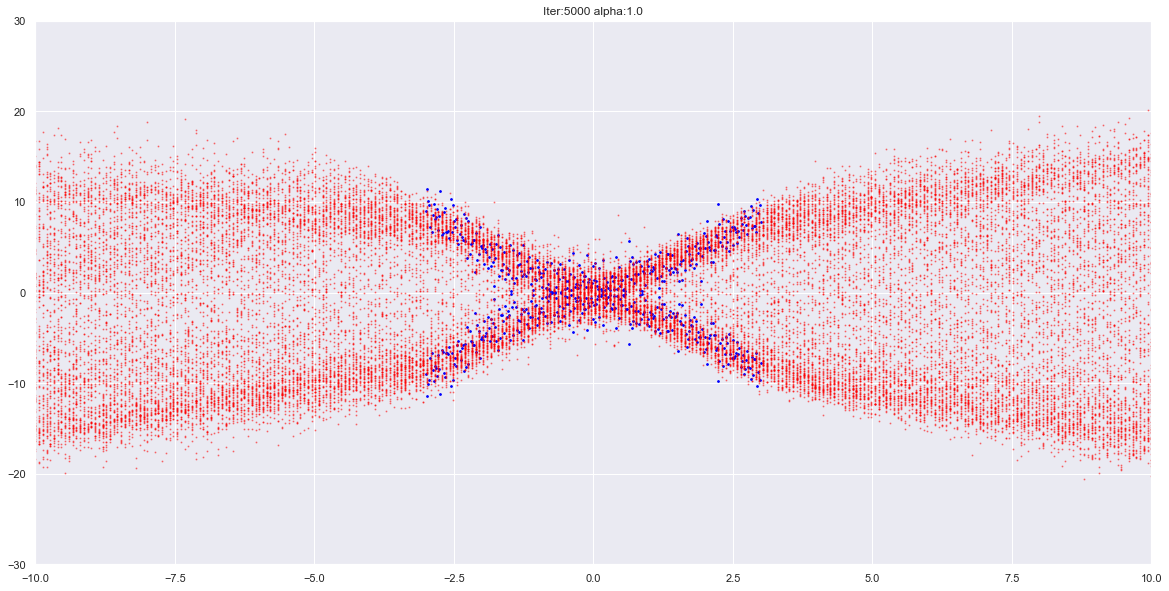

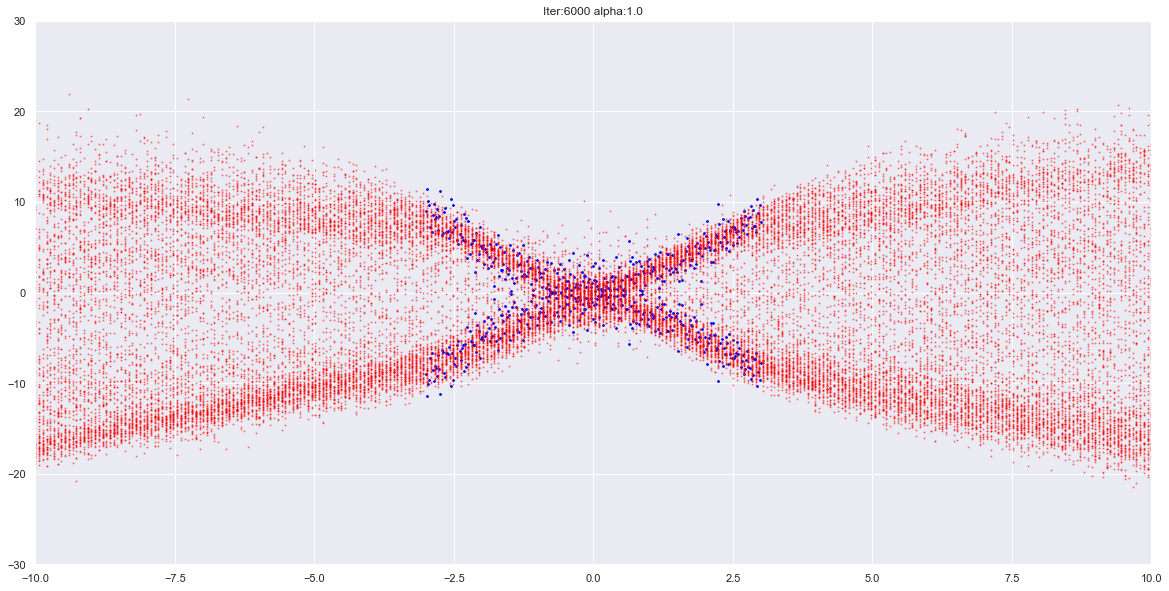

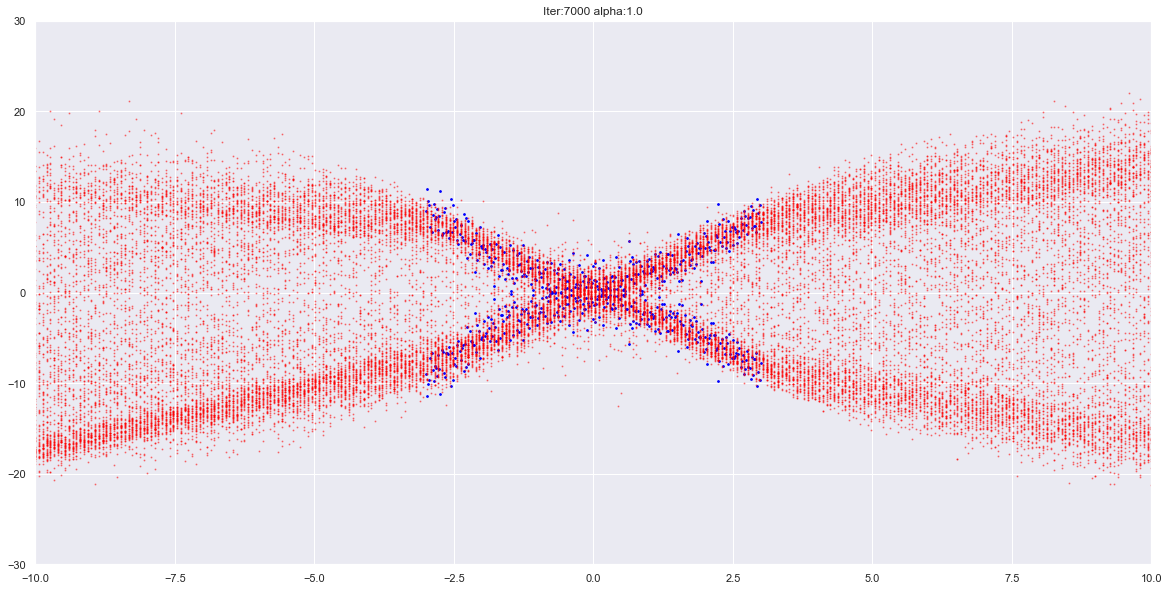

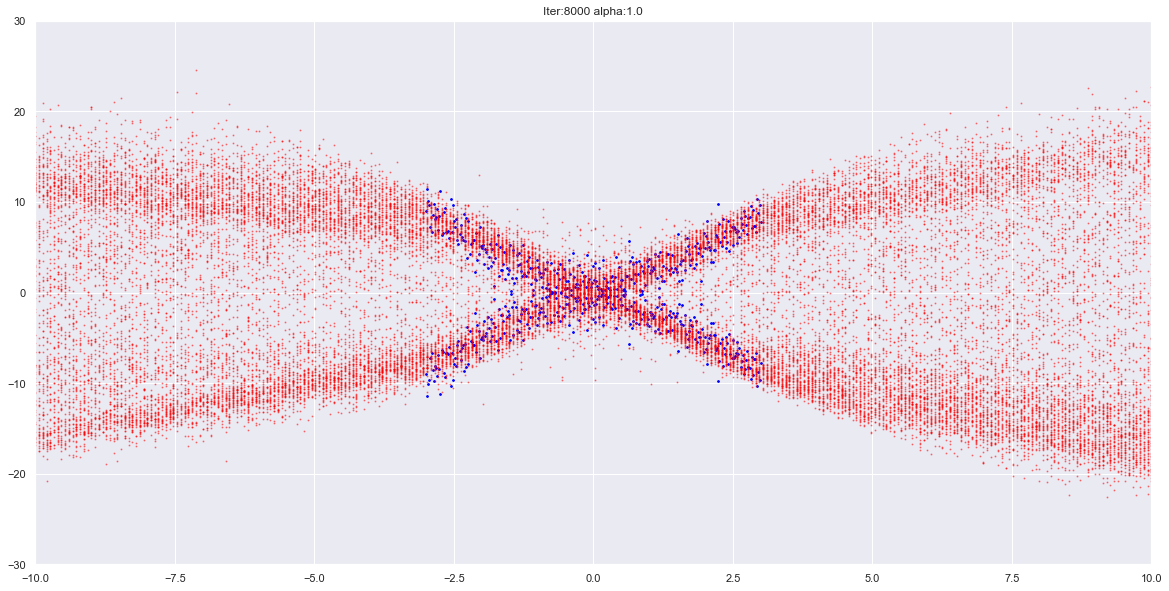

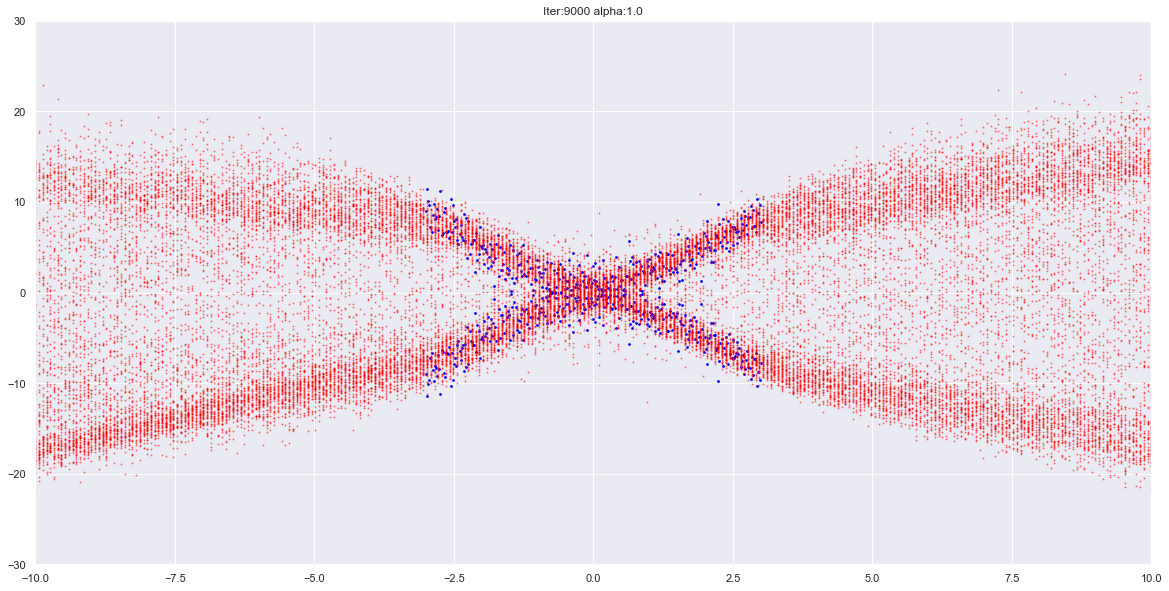

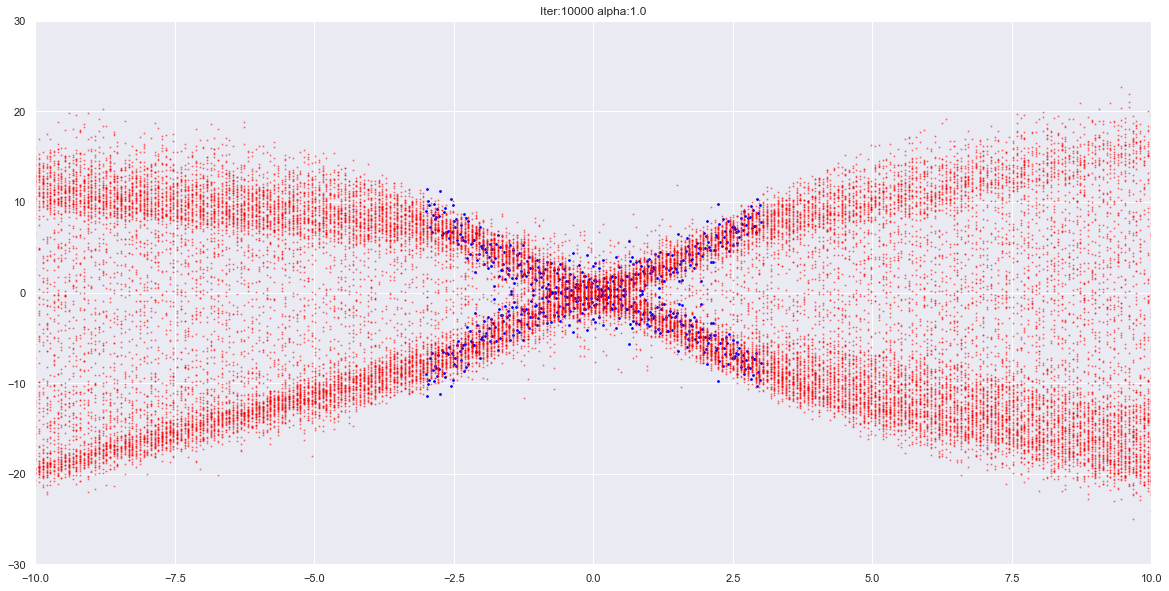

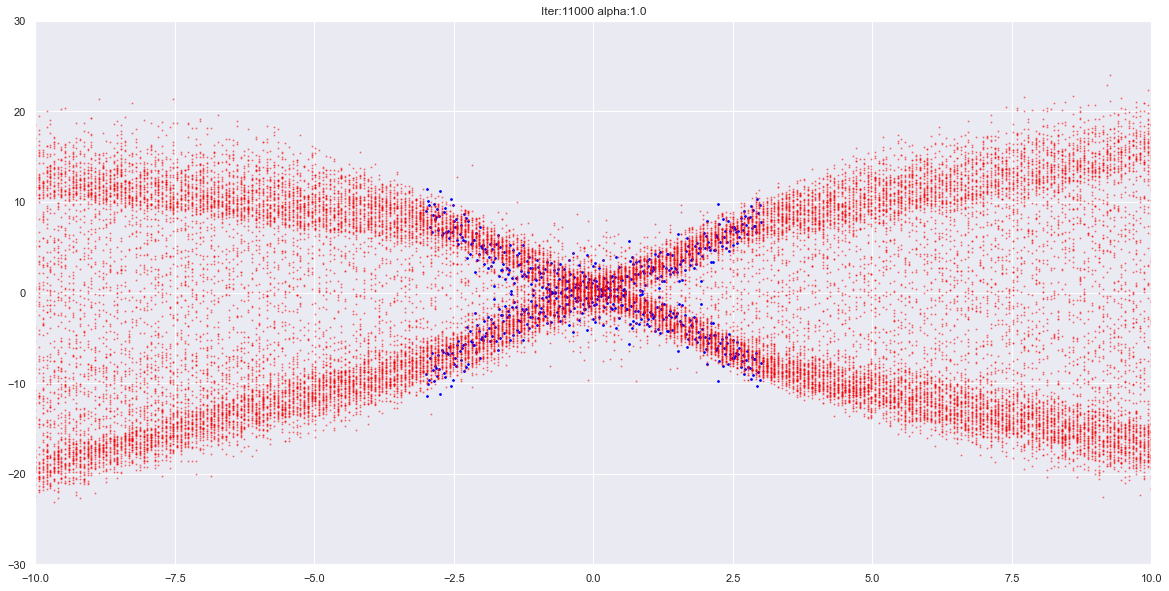

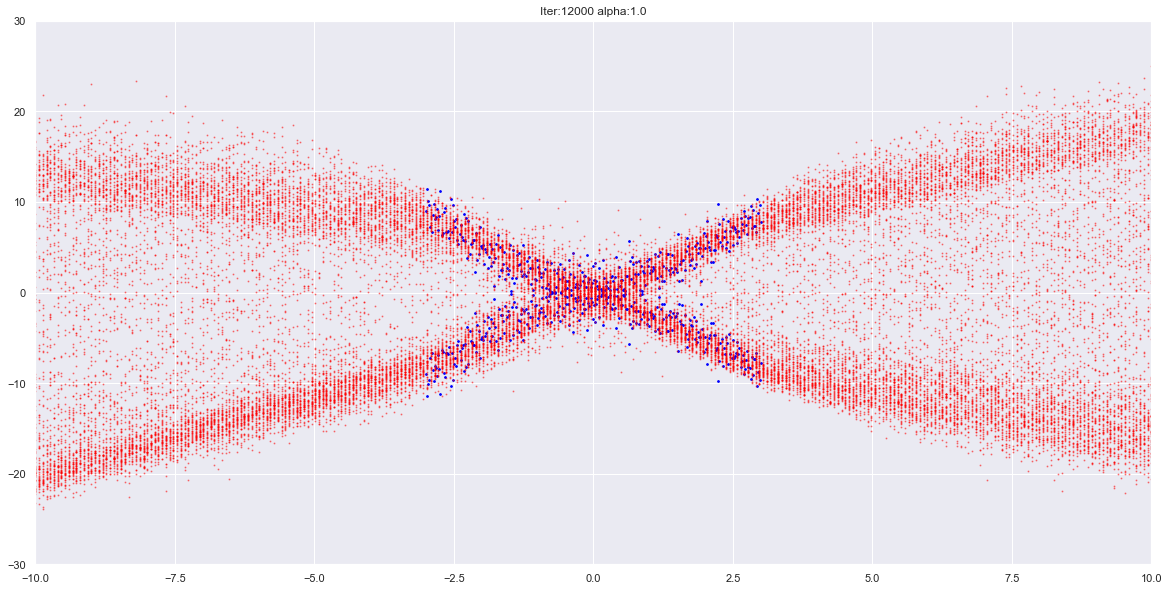

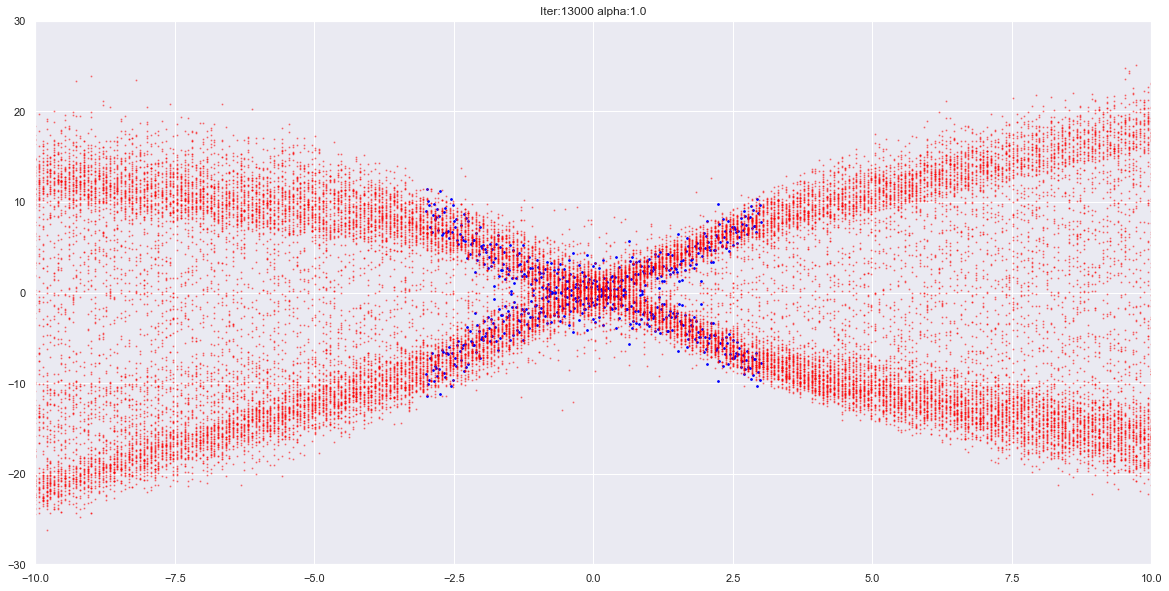

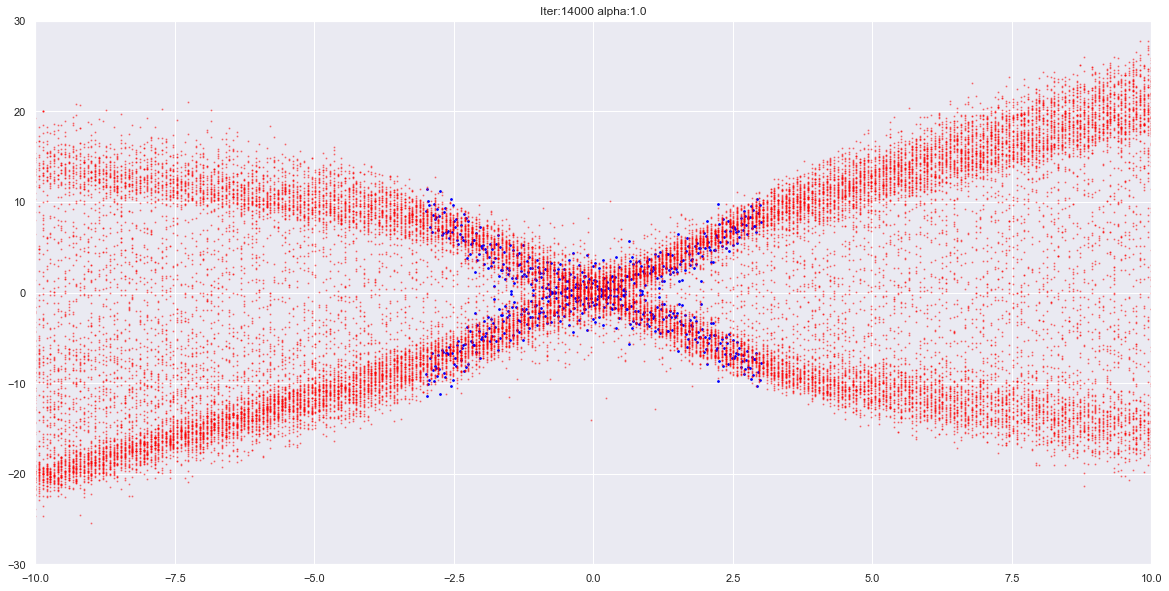

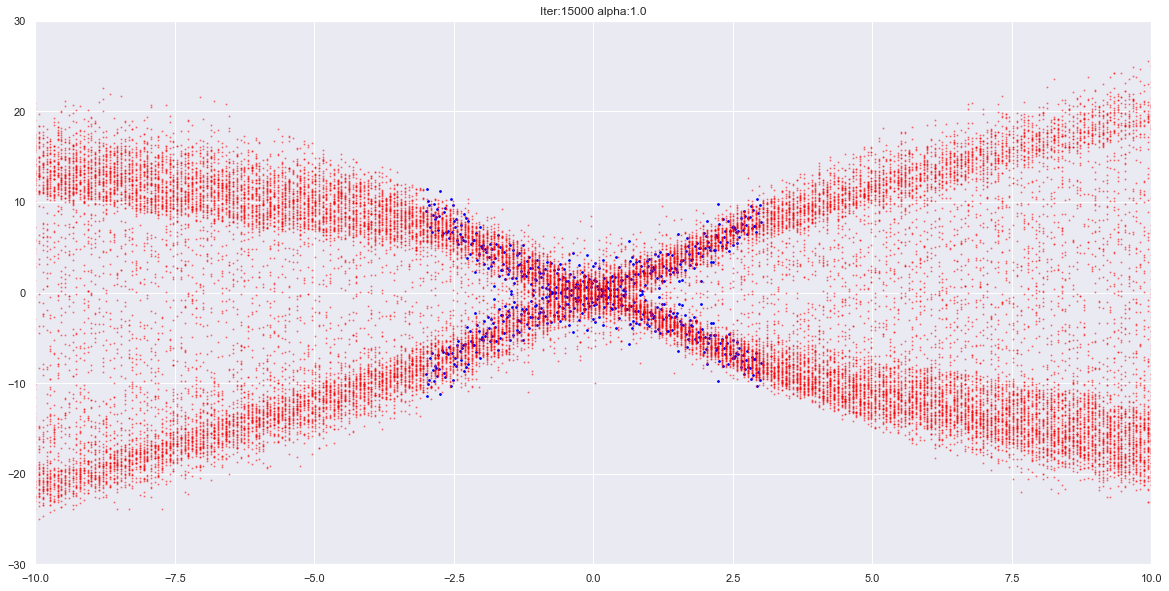

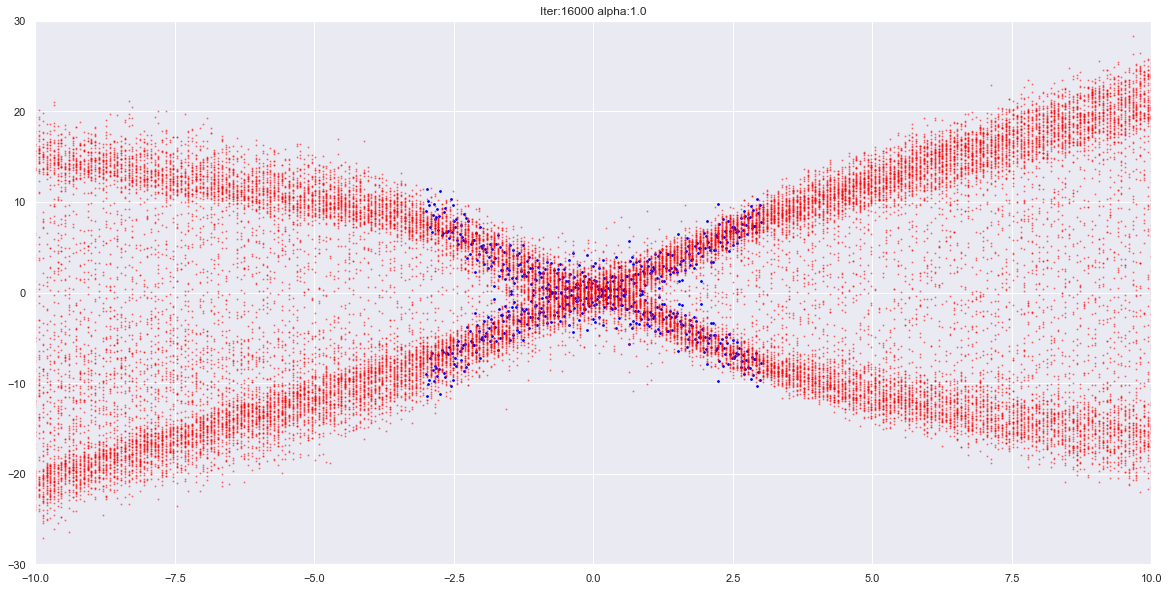

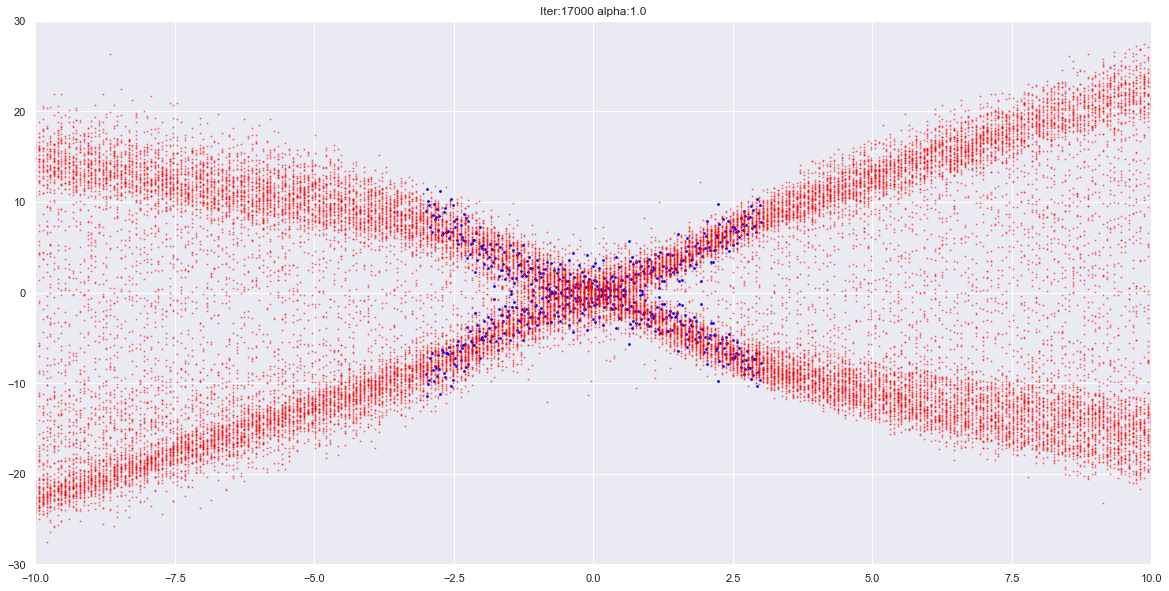

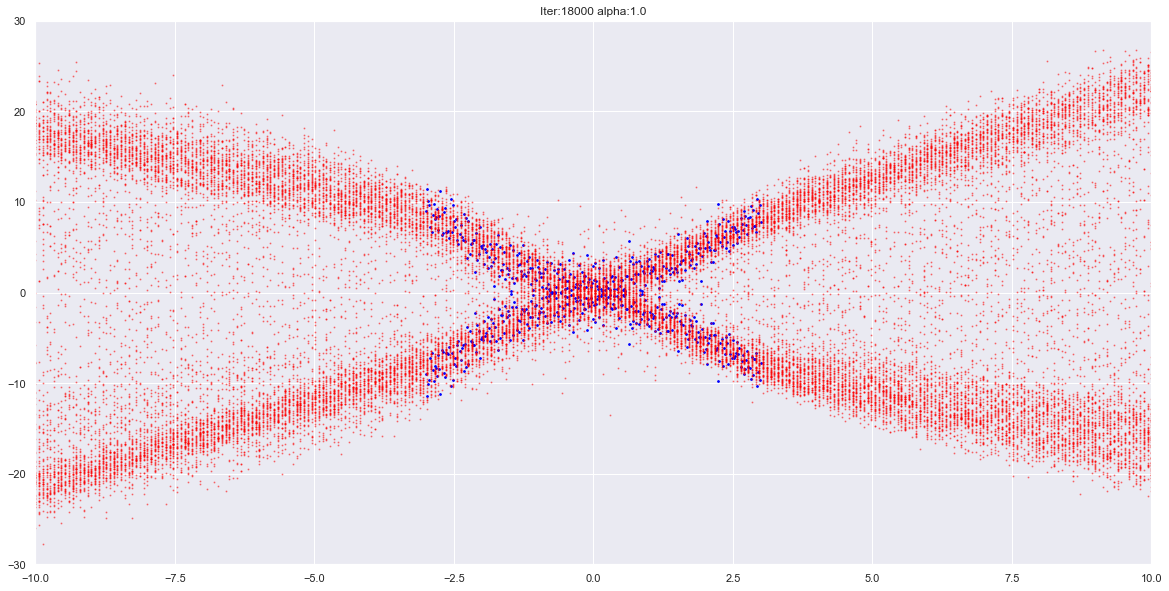

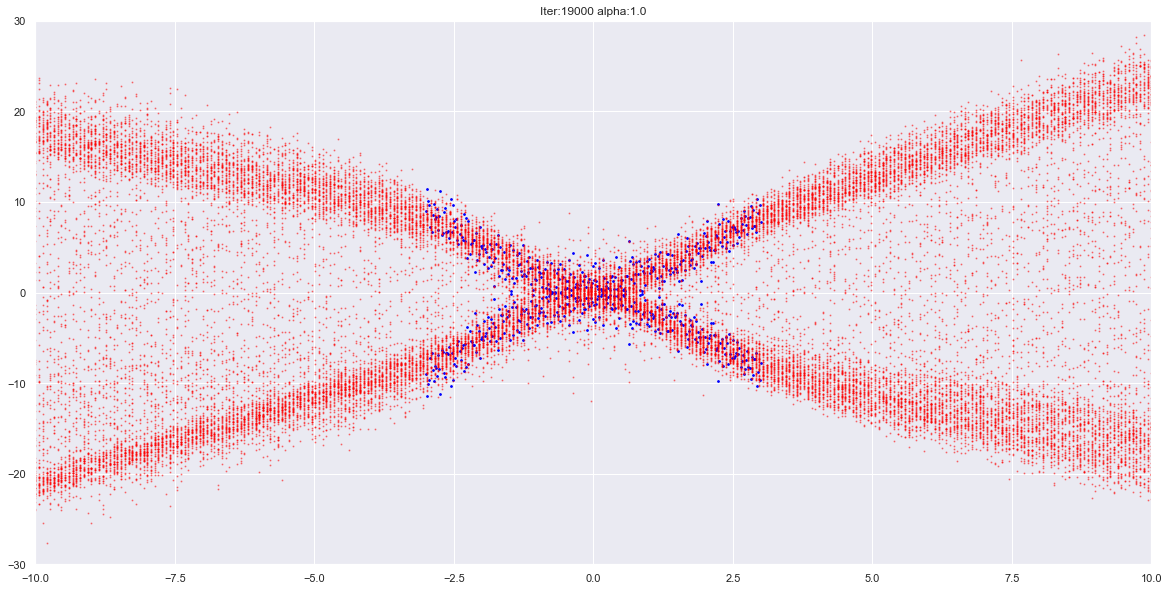

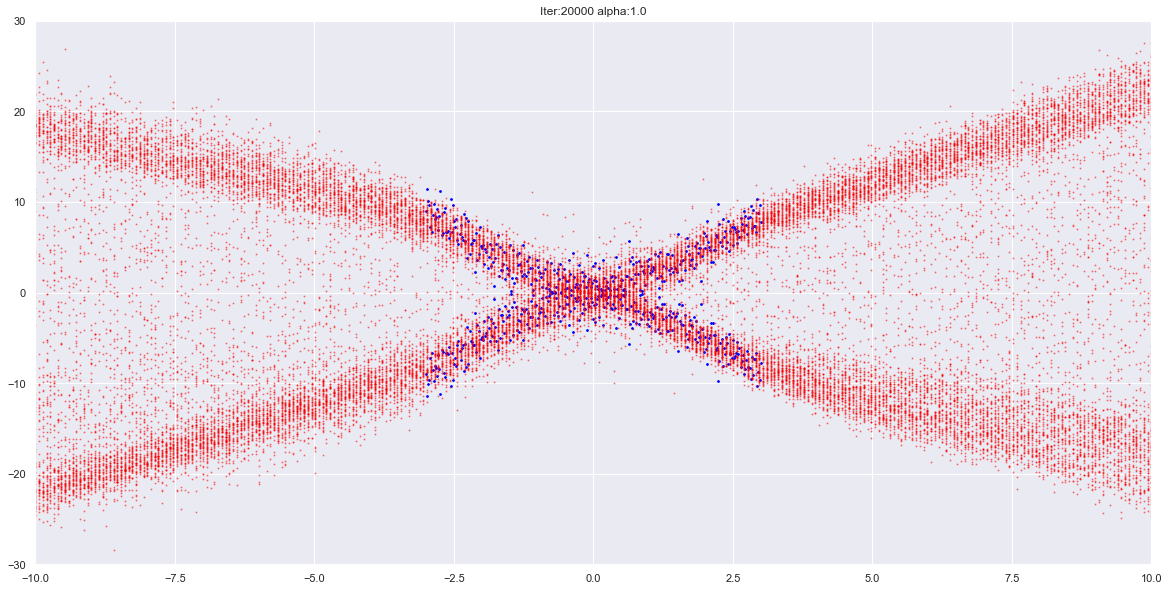

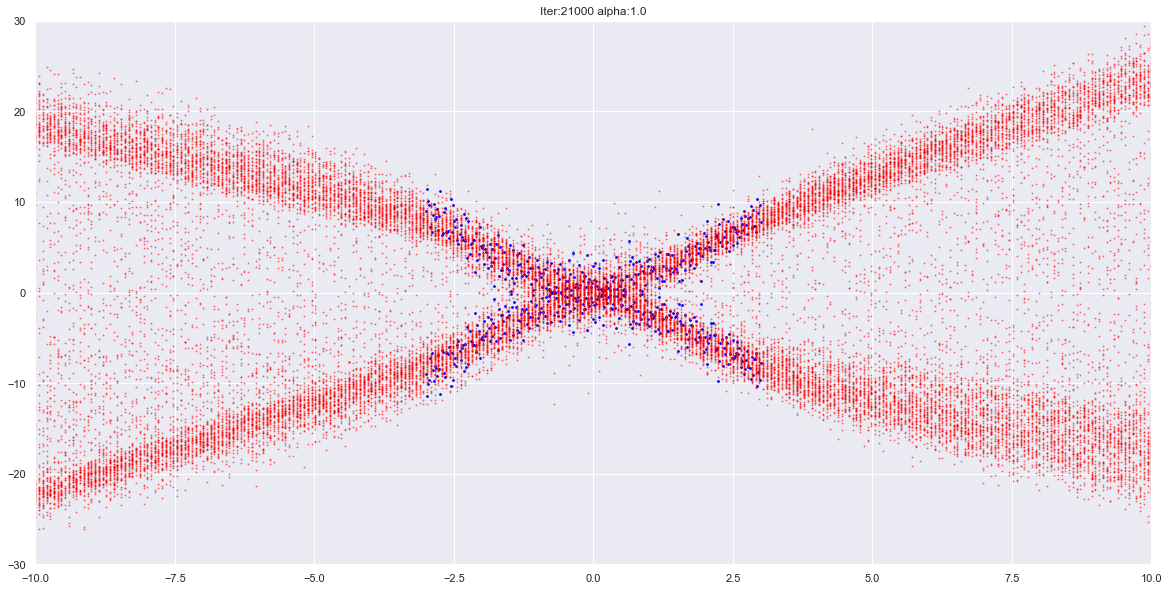

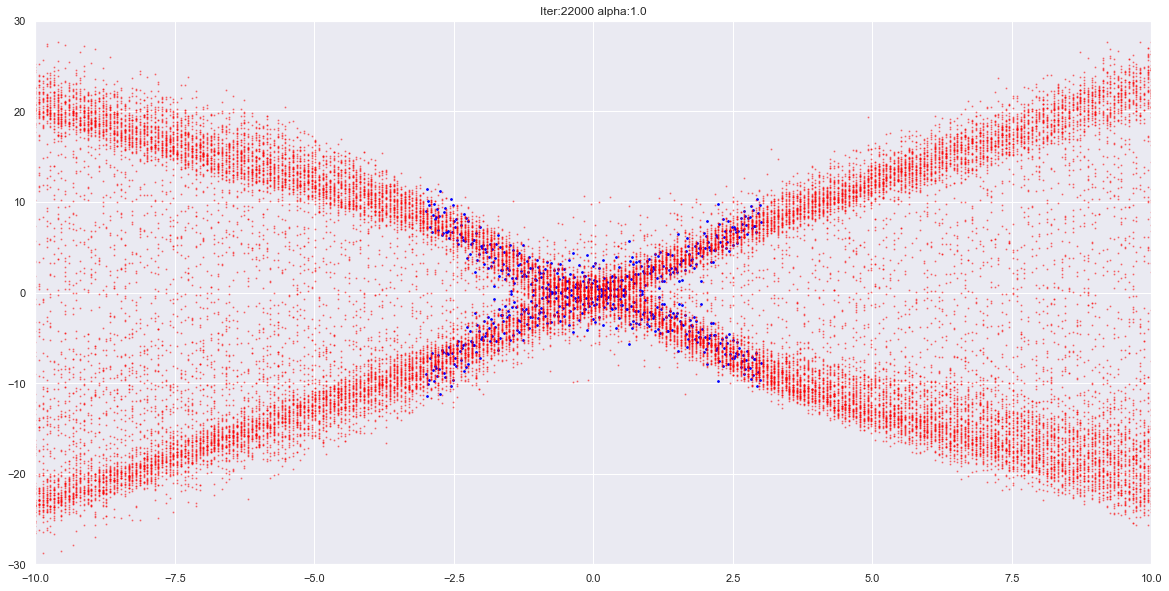

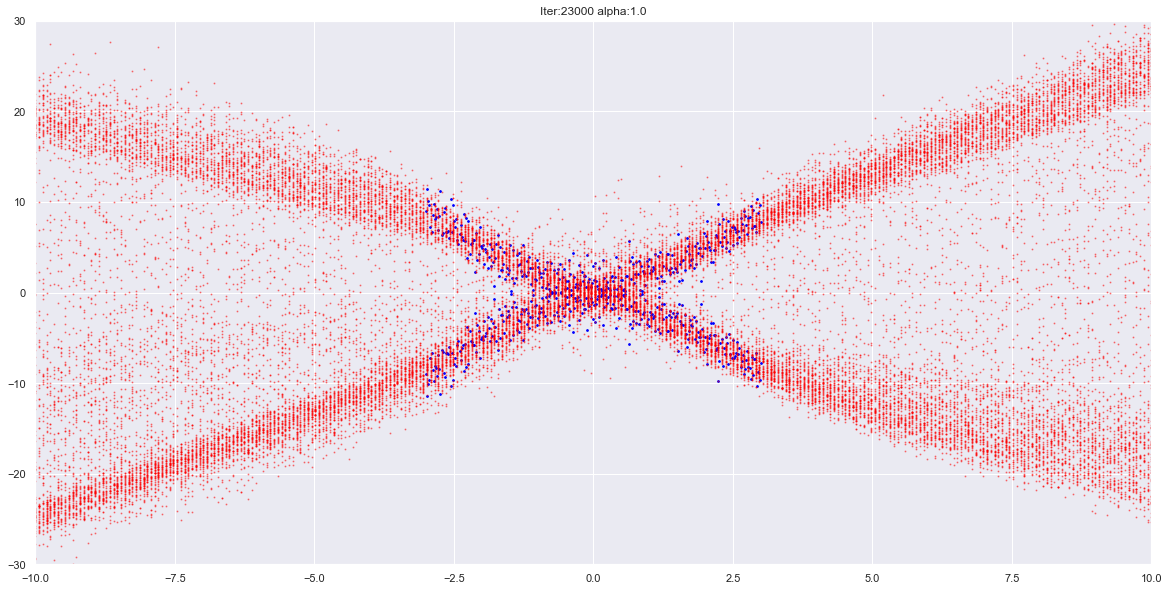

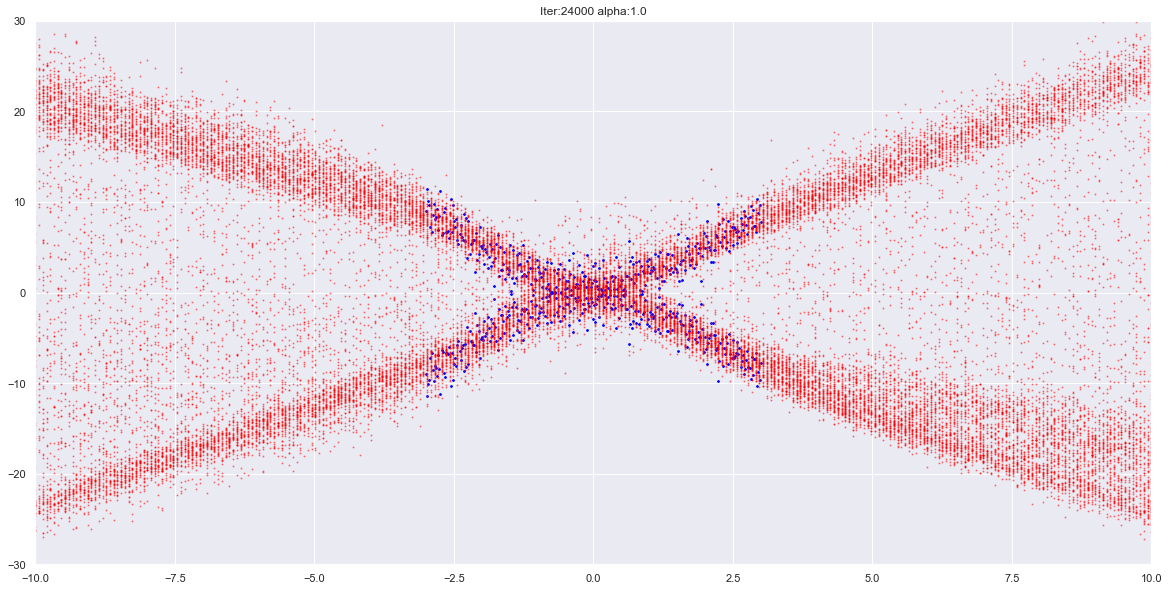

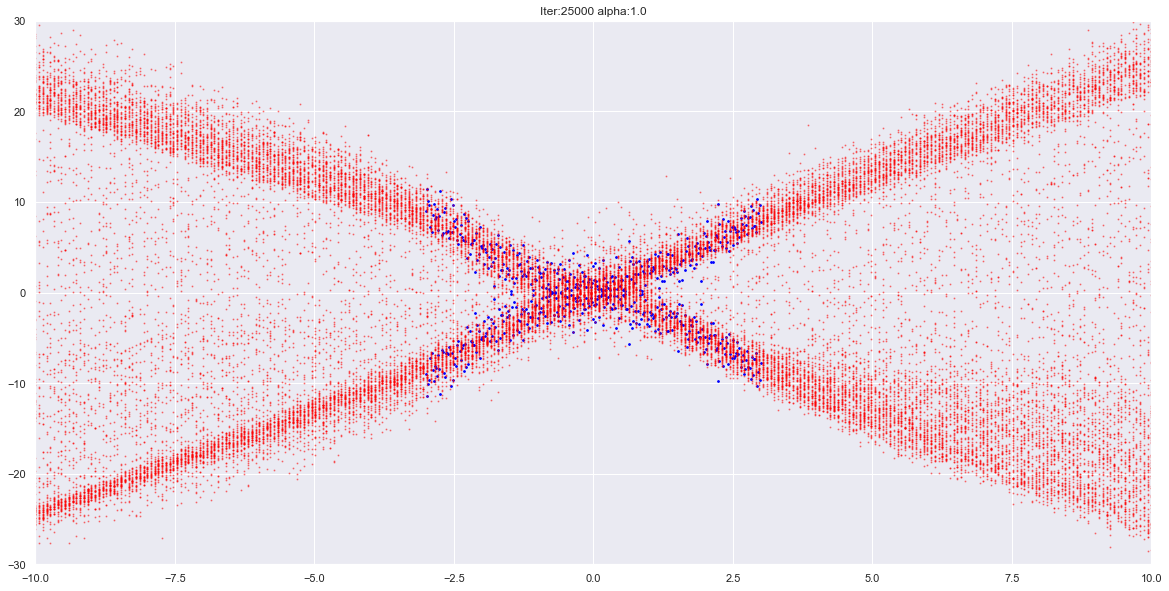

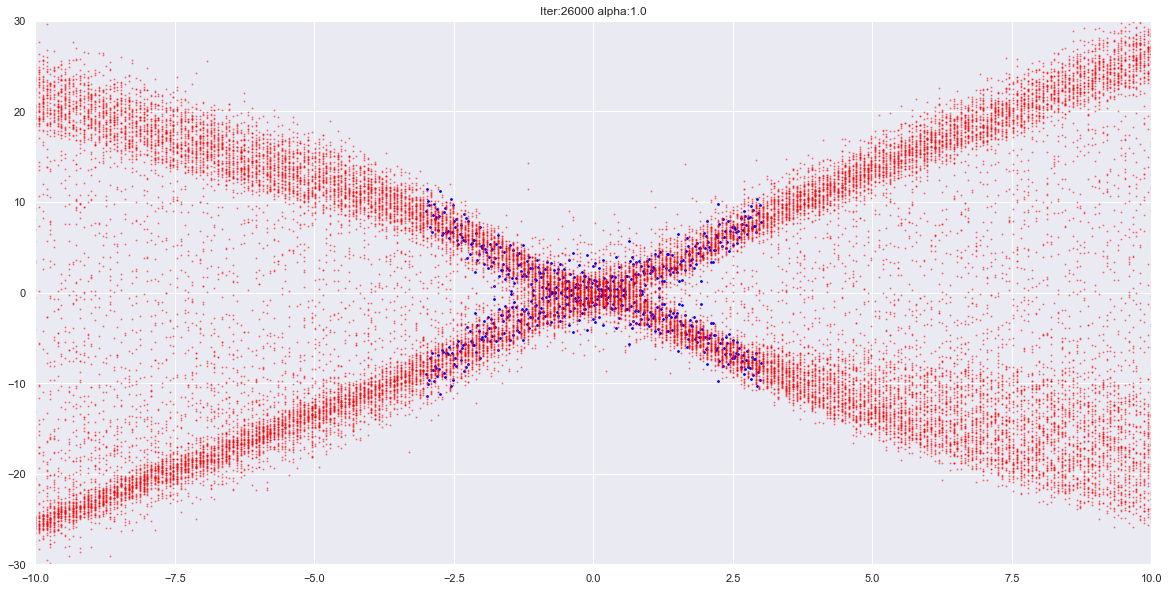

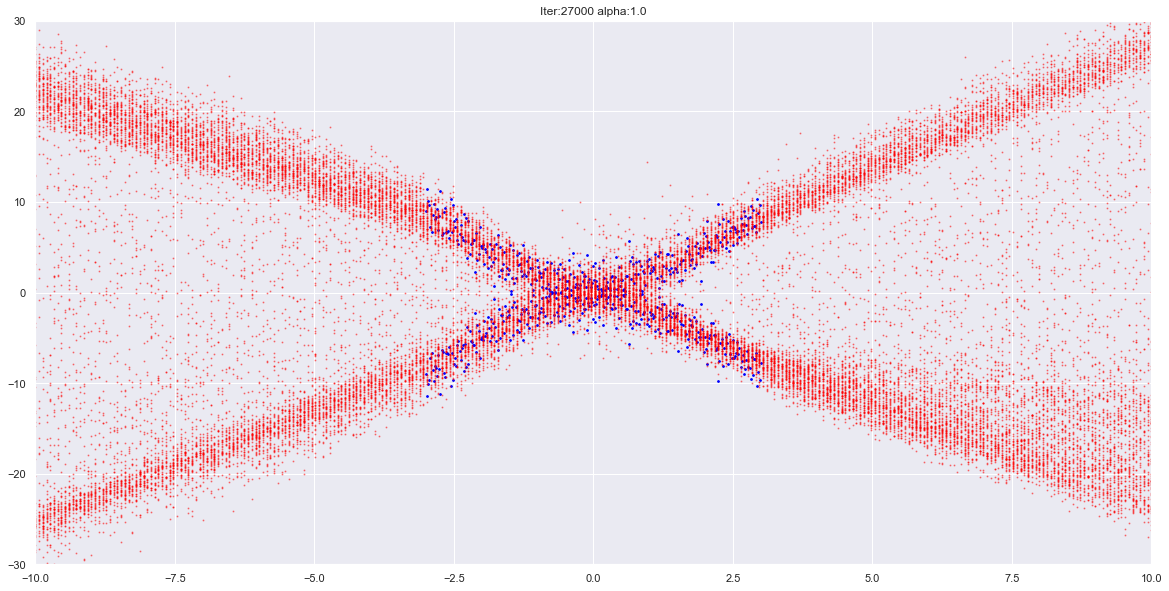

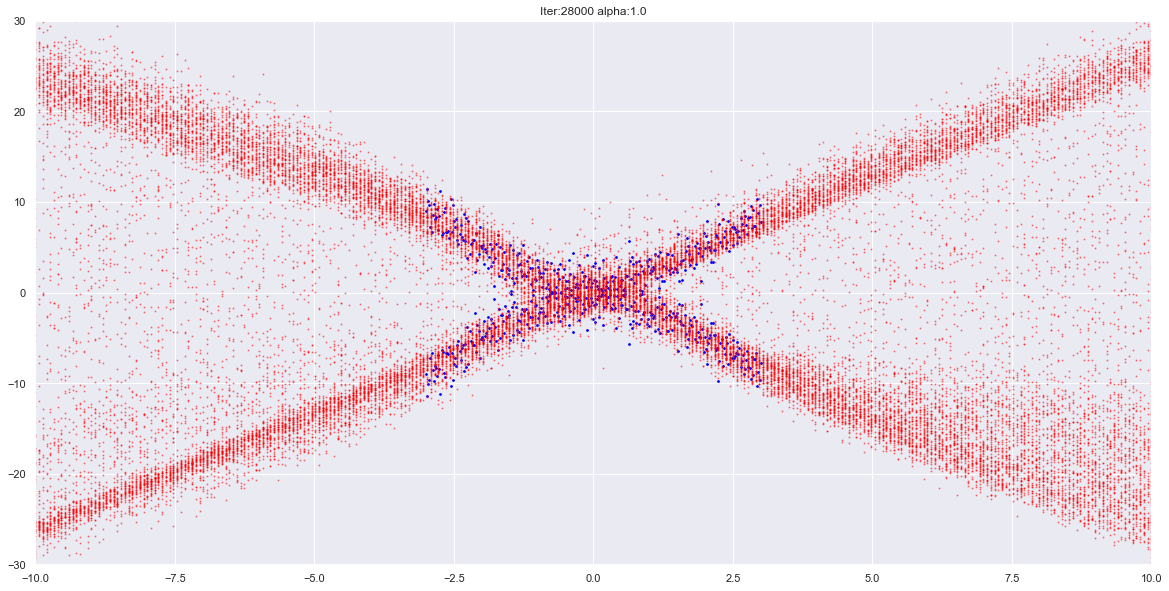

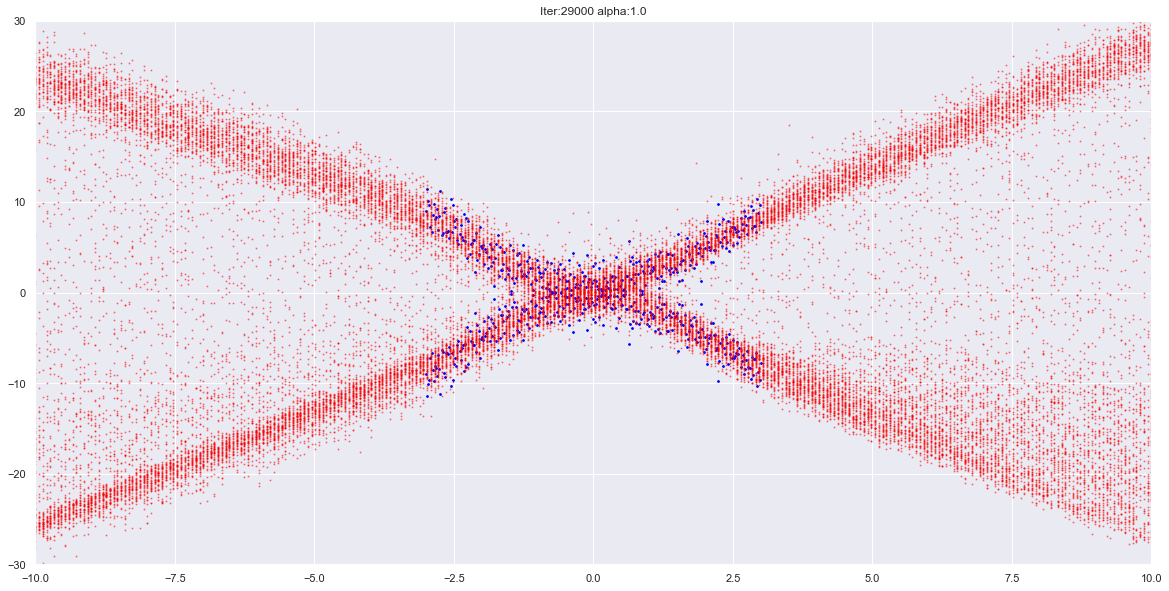

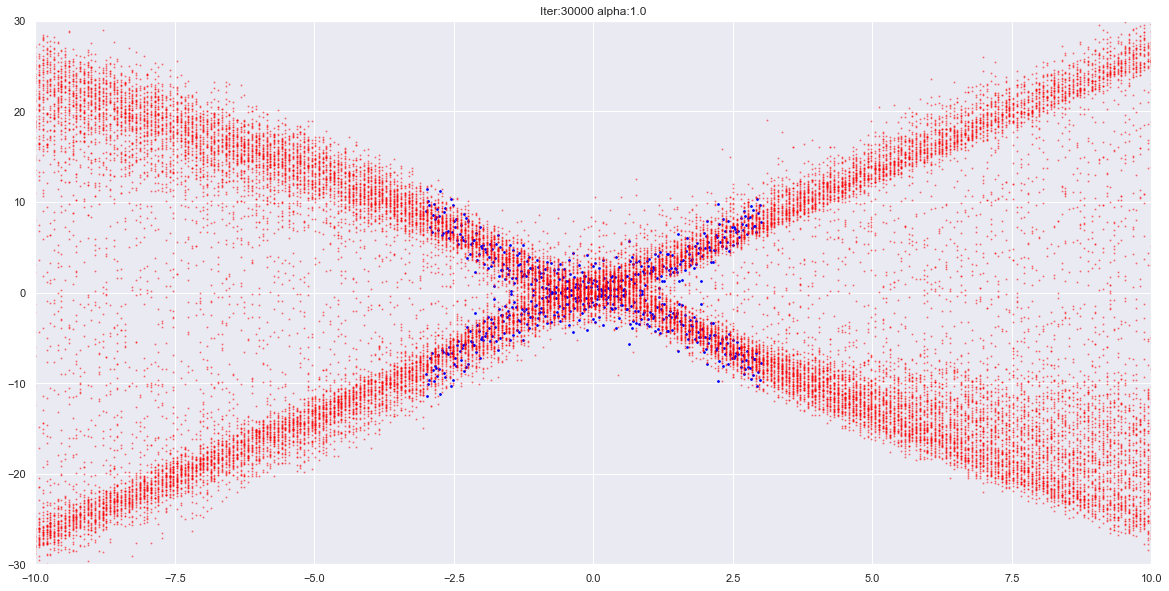

In [15]:
TRAIN_PARTICLES = 10
NUM_PARTICLES = 100
ITER_NUM = int(3e4)
BATCH_SIZE = 32
IMAGE_SHOW = 1e+3

def train(alpha=1.0):
    for i in range(ITER_NUM):
        # sample minibatch
        index = np.random.choice(range(len(x)), size=BATCH_SIZE, replace=False)
        mini_x = x[index]
        mini_y = y[index]

        # eval_svgd
        eval_svgd(g_net,d_net, mini_x, mini_y, num_particle=TRAIN_PARTICLES)
        
        # sample minibatch
        index = np.random.choice(range(len(x)), size=BATCH_SIZE, replace=False)
        mini_x = x[index]
        mini_y = y[index]
        
        # learn discriminator
        d_learn(g_net,d_net, mini_x, mini_y, num_particle=TRAIN_PARTICLES)

        if (i+1)%IMAGE_SHOW == 0:
            plt.rcParams["figure.figsize"] = (20,10)
            fig, ax = plt.subplots()
            plt.xlim(-10,10)
            plt.ylim(-30,30)
            x_test = np.linspace(-10,10, 300).reshape(-1,1)
                        
            ax.scatter(x, y,s=3,color='blue')
            
            predict = g_net.forward(Variable(torch.FloatTensor(x_test)).cpu(),\
                                     num_particle=NUM_PARTICLES).detach().cpu().numpy()
            
            ax.scatter(list(np.linspace(-10,10, 300))*NUM_PARTICLES,\
                       predict.transpose(1,0,2).reshape(-1)\
                       ,s=1, alpha=0.4, color='red')
            
            ax.set_title('Iter:'+str(i+1)+' alpha:'+str(alpha))
            plt.show()

g_net = G().cpu()
d_net = D().cpu()
g_optim = torch.optim.Adam(g_net.parameters(), lr=1e-3)
d_optim = torch.optim.Adam(d_net.parameters(), lr=1e-4)
train(1.)